# Reading annotations

In [1]:
# laoding the mat annotation in python
import scipy.io
from functools import reduce, partial
import numpy as np

In [11]:
mat = scipy.io.loadmat("../data/PASCAL_PARTS/Annotations_Part/2008_000007.mat")
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'anno'])

Understanding the annotations

In [12]:
# getting image name
image_name = mat["anno"][0][0][0][0]

In [2]:
import matplotlib.pyplot as plt

In [24]:
from collections import namedtuple

# type for annotation
# Annotation = namedtuple("Annotation", ["name", "mask", "children"])
Annotation = lambda name, mask, children: (name, mask, children)

In [8]:
np.identity(3, dtype=int) == 1

array([[ True, False, False],
       [False,  True, False],
       [False, False,  True]])

In [25]:
def getAnnotationTree(mat) -> list:
    """Generate annotation tree from PASCAL mat file

    Args:
        mat (dict): loaded mat file dict of pascal parts

    Returns:
        list: [(name:str, mask:numpy.array), None|List]
    """
    
    ann = []
    root = None
    
    # annotation
    for elem in mat["anno"][0][0][1]:    
        # objects
        for nelem in elem:
            nest = []
            # nested parts
            for part in nelem[3]:
                part = part[0]
                nest.append(Annotation(part[0][0], part[1] == 1, []))
            
            if root is None:
                root = np.ones_like(nelem[2] == 1)
                # root[root>=1] = 1
            # else:
                # root = np.copy(nelem[2])
                
            ann.append(Annotation(nelem[0][0], nelem[2] == 1, nest))
    
    return Annotation("root", root, ann)

In [26]:
tree = getAnnotationTree(mat)

In [29]:
def printTree(tree, tab=0):
    print("\t"*tab, tree[0])
    for t in tree[2]:
        printTree(t, tab+1)

In [30]:
printTree(tree)

 root
	 boat


In [31]:
tree

('root',
 array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 [('boat',
   array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]),
   [])])

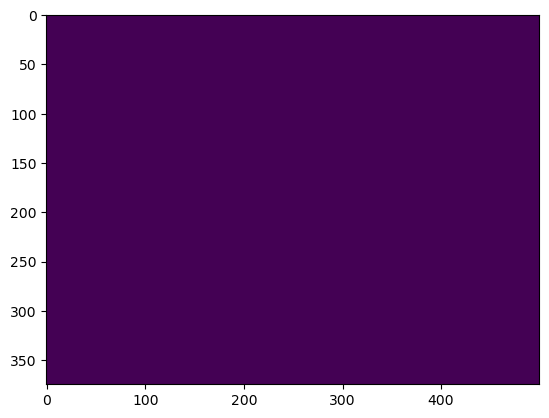

In [32]:
# 0: name
# 1: class index
# 2: mask
# 3: child object(s?)

plt.imshow(tree[1])

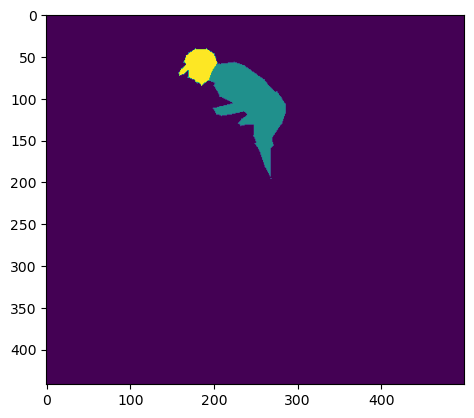

In [74]:
obj = mat["anno"][0][0][1][0][0][3]

plt.imshow(mat["anno"][0][0][1][0][0][2] + obj[0][0][1])

## Hierarchy definitions

use IOU threshold to decide the masks that are shown

**Create a function that takes attention mask and annotations as input and creates the largest object fragments within attention area**

In [48]:
np.array([1,0,0,1]) | np.array([0,0,1,1])

array([1, 0, 1, 1])

In [33]:
def generateAnnotationMask(annotation: tuple, attentionMask: np.ndarray, threshold: float=0.1) -> np.ndarray:
    
    attentionMaskSum = np.sum(attentionMask)
    annotationMask = np.zeros_like(attentionMask)
    
    def _inorder(ann):
        mask = attentionMask & ann[1]
        intersection = np.sum(mask)
        if (attentionMaskSum-intersection)/attentionMaskSum > threshold:
            nonlocal annotationMask
            annotationMask = annotationMask | mask
            return
        
        for child in ann[2]:
            _inorder(child)
            
    _inorder(annotation)
    
    return annotationMask

In [34]:
printTree(tree)

 root
	 boat


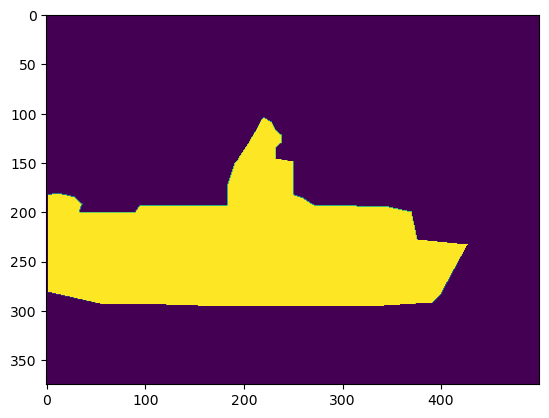

In [36]:
plt.imshow(tree[2][0][1])

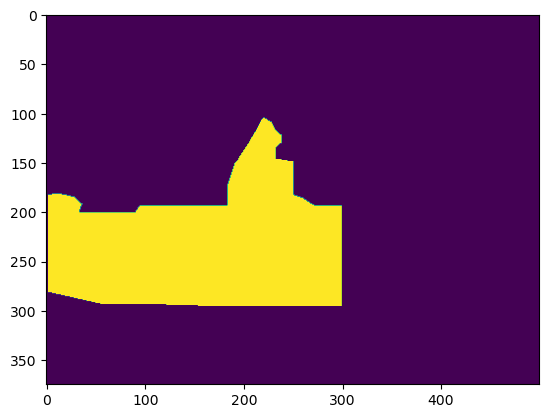

In [38]:
mask = np.zeros_like(tree[1])
mask[0:400, 0: 300] = 1
plt.imshow(generateAnnotationMask(tree, mask))

# Read JSON representation

In [20]:
import cv2

def dictToAnnotation(data: dict):
    size = (data["height"], data["width"])
    image = data["Image"]
    
    def _genAnnotations(image):
        mask = np.zeros(size)
        # getting the polygon points
        vertices = []
        for i in range(0, len(image["mask"]), 2):
            vertices.append([
                round(image["mask"][i] * (size[1]-1)),
                round(image["mask"][i+1] * (size[0]-1))
            ])
        
        vertices = np.array([vertices], dtype=np.int32)

        cv2.fillPoly(mask, vertices, color=1)
        
        children = []
        for child in image["children"]:
            children.append(_genAnnotations(child))
            
        return Annotation(image["name"], mask == 1, children)
    
    return _genAnnotations(image)

In [21]:
import json

with open("./_test.json") as j:
    data = json.load(j)
    test = dictToAnnotation(data)


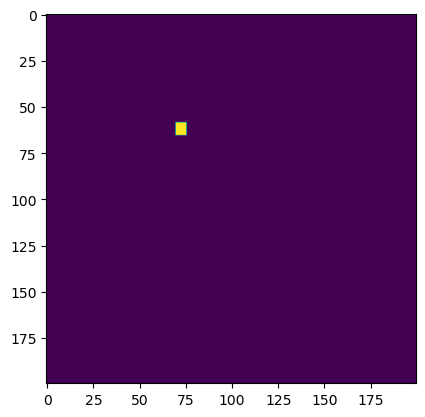

In [22]:
plt.imshow(test.children[1].children[0].children[0].mask)

# Reader for RNN flat annotations

Level 1 -> Level 2 -> Level 3 -> ...

In [42]:
import json
import numpy as np 
import matplotlib.pyplot as plt

with open("./_test.json") as j:
    data = json.load(j)

In [39]:
import cv2

def dictToRNNAnnotation(data: dict):
    size = (data["height"], data["width"])
    image = data["Image"]
    
    queue = [(1, c)for c in [*image["children"]]]
    masks = []
    while queue:
        child = queue.pop(0)
        
        # process
        if len(masks) < child[0]:
            masks.append(np.zeros(size))
            
        vertices = []
        for i in range(0, len(child[1]["mask"]), 2):
            vertices.append([
                round(child[1]["mask"][i] * (size[1]-1)),
                round(child[1]["mask"][i+1] * (size[0]-1))
            ])
        
        vertices = np.array([vertices], dtype=np.int32)

        cv2.fillPoly(masks[-1], vertices, color=1)
        # end process
          
        # add children
        for c in child[1]['children']:
            queue.append((child[0]+1, c))
    
    return masks

In [40]:
masks = dictToRNNAnnotation(data)

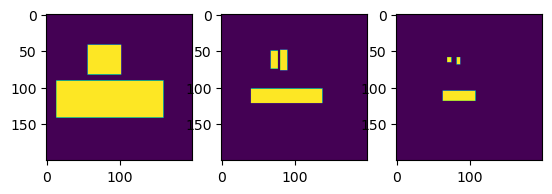

In [43]:
for i, m in enumerate(masks):
    plt.subplot(1, len(masks), i+1)
    plt.imshow(m)